In [1]:
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from scipy.stats import mannwhitneyu, wilcoxon
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.plot_scores import *

plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=16)  # fontsize of the axes title
plt.rc('axes', labelsize=14)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)  # fontsize of the tick labels
plt.rc('ytick', labelsize=14)  # fontsize of the tick labels
plt.rc('legend', fontsize=14)  # legend fontsize

sns.set_context("paper")

<Figure size 400x400 with 0 Axes>

In [2]:
df_krogan = pd.read_csv('../results/krogan_lab_datasets/only_best_model/all/results_published_datasets_onlybestmodel_deduplicated_with_info.csv')
df_krogan['Dataset'] = 'AP-MS'
print(df_krogan.shape)
df_hpidb = pd.read_csv('../results/hpidb/hpidb_filtered_af2_results_deduplicated_with_info.csv')
print(df_hpidb.shape)
df_hpidb['Dataset'] = 'HPIDB'
df_both = pd.read_csv('../results/merged_results/krogan_lab_hpidb_results_deduplicated.csv')
print(df_both.shape)
print(df_both[df_both['iptm'] >= 0.5].shape)

(5151, 35)
(1391, 18)
(6542, 35)
(803, 35)


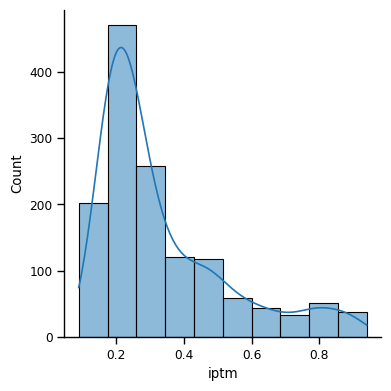

In [3]:
sns.displot(x=df_hpidb['iptm'], kde=True, bins=10, height=4, aspect=1)
plt.show()

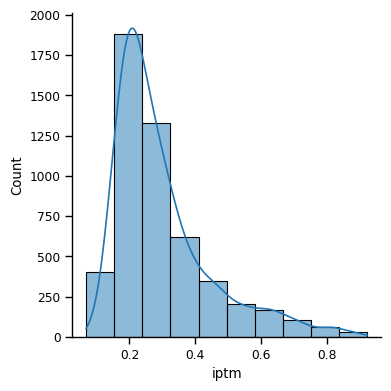

In [4]:
sns.displot(x=df_krogan['iptm'], kde=True, bins=10, height=4, aspect=1)
plt.show()

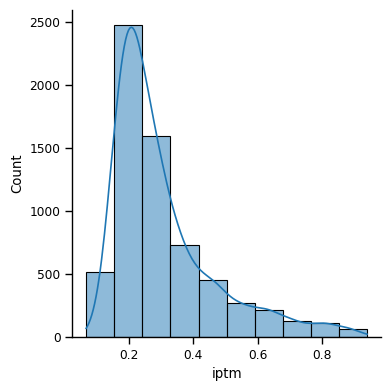

In [5]:
sns.displot(x=df_both['iptm'], kde=True, bins=10, height=4, aspect=1)
plt.show()

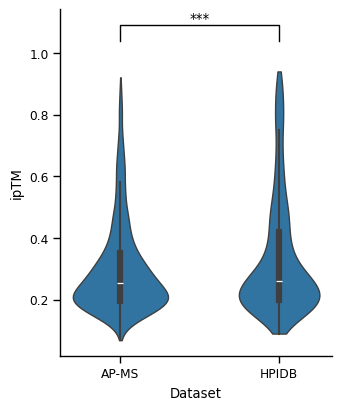

In [6]:
plot_comparison(df_krogan, df_hpidb, column='Dataset', metric='iptm', output_filepath='../results/plots_apms_hpidb/hpidb_vs_krogan.svg', 
                plot_type='violinplot', figsize=(3.5, 4.5))

#### AF3

In [8]:
krogan_af3_df = pd.read_csv('../results/krogan_lab_datasets/af3/krogan_lab_datasets_af3_results_deduplicated.csv')
hpidb_af3_df = pd.read_csv('../results/hpidb/af3/hpidb_af3_results_deduplicated.csv')
print(krogan_af3_df[krogan_af3_df['iptm'] >= 0.5].shape[0] / krogan_af3_df.shape[0])
print(hpidb_af3_df[hpidb_af3_df['iptm'] >= 0.5].shape[0] / hpidb_af3_df.shape[0])
print(krogan_af3_df.shape)
print(hpidb_af3_df.shape)

0.0504406525407838
0.1267605633802817
(5333, 12)
(1420, 12)


In [9]:
df_both_af3 = pd.concat([krogan_af3_df, hpidb_af3_df], axis=0, ignore_index=True)
df_both_af3.shape

(6753, 12)

In [10]:
print(df_both[df_both['iptm'] >= 0.5].shape)
print(df_both_af3[df_both_af3['iptm'] >= 0.5].shape)

(803, 35)
(449, 12)


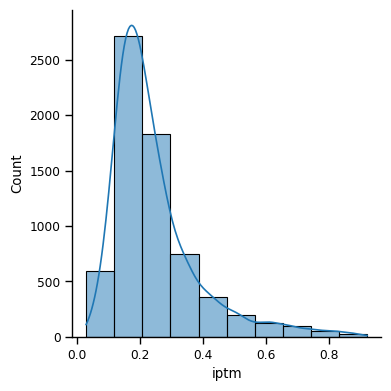

In [11]:
sns.displot(x=df_both_af3['iptm'], kde=True, bins=10, height=4, aspect=1)

6540


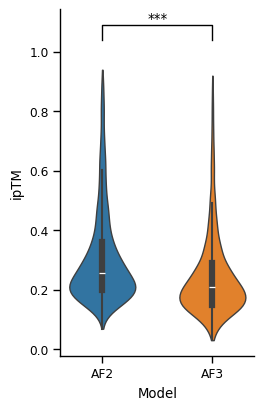

In [12]:
df_both['name'] = df_both['name'].str.upper().str.replace('^', '-')
pairs_in_af2_and_af3 = set(df_both['name'].to_list()).intersection(set(df_both_af3['name'].to_list()))
print(len(pairs_in_af2_and_af3))
df_both['Model'] = 'AF2'
df_both_af3['Model'] = 'AF3'
plot_comparison_paired_test(df_both, df_both_af3, 'Model', 'iptm', output_filepath='../results/plots_apms_hpidb/krogan_hpidb_af2_vs_af3.svg', 
                            plot_type='violinplot', figsize=(2.5, 4.5))

In [13]:
print(100*df_both[df_both['iptm'] >= 0.5].shape[0] / df_both.shape[0])
print(100*df_both_af3[df_both_af3['iptm'] >= 0.5].shape[0] / df_both_af3.shape[0])

12.274533781718128
6.648896786613357


In [14]:
print(df_both.shape)
print(df_both_af3.shape)

(6542, 36)
(6753, 13)


#### Results per pathogen

In [16]:
organism_df = pd.read_table('../data/hpidb2/idmapping_2024_11_04.tsv', header=0, sep='\t')
organism_short_names_df = pd.read_csv('../data/hpidb2/hpidb_filtered/organism_abbreviations.csv')
df_hpidb_organisms = df_hpidb.merge(organism_df[['From', 'Organism']], how='left', left_on='pathogen_protein', right_on='From')
df_hpidb_organisms.drop(['From'], axis=1, inplace=True)
df_hpidb_organisms['Organism'] = df_hpidb_organisms['Organism'].str.split('(').str[0].str.strip()
df_hpidb_organisms = df_hpidb_organisms.merge(organism_short_names_df, how='left', left_on='Organism', right_on='organism')
df_hpidb_organisms.rename(columns={'organism_short': 'pathogen'}, inplace=True)

In [17]:
def get_pathogen(x):
    if 'SARS-CoV1' in x['name']:
        pathogen = 'SARS-CoV'
    elif 'SARS-CoV2' in x['name']:
        pathogen = 'SARS-CoV-2'
    elif 'Mtb' in x['name']:
        pathogen = 'M. tuberculosis'
    elif 'Chlamydia' in x['name']:
        pathogen = 'C. trachomatis'
    elif 'ZIKVfp' in x['name']:
        pathogen = 'ZIKV'
    elif 'HIV' in x['name']:
        pathogen = 'HIV-1'
    elif 'DENV' in x['name']:
        pathogen = 'DENV-2'
    elif 'Ebola' in x['name']:
        pathogen = 'EBOV'
    elif 'HPV-31' in x['name']:
        pathogen = 'HPV-31'
    else:
        pathogen = x['name'].split('-')[0]
    return pathogen

df_krogan['pathogen'] = df_krogan.apply(get_pathogen, axis=1)
df_both_with_pathogens = pd.concat([df_krogan, df_hpidb_organisms], axis=0, ignore_index=True)
df_both_with_pathogens_selected = df_both_with_pathogens[df_both_with_pathogens['iptm'] >= 0.5]
both_all_val_counts = df_both_with_pathogens['pathogen'].value_counts()
both_all_val_counts_top = both_all_val_counts[both_all_val_counts > 50] # previously 10
both_selected_val_counts = df_both_with_pathogens_selected['pathogen'].value_counts()
# add missing pathogens (because none of the pairs that were modeled had an iptm score >= 0.5)
missing = list(set(both_all_val_counts.index.tolist()).difference(set(both_selected_val_counts.index.tolist())))
missing_series = pd.Series(data={k: 0 for k in missing})
both_selected_val_counts = pd.concat([both_selected_val_counts, missing_series])
both_selected_val_counts_top = both_selected_val_counts[both_all_val_counts_top.index]
both_all_val_counts_top['Other'] = np.sum(both_all_val_counts[both_all_val_counts < 50]) # previously 10
both_selected_val_counts_top['Other'] = np.sum(both_selected_val_counts[both_all_val_counts[both_all_val_counts < 50].index]) # previously 10
print(both_all_val_counts_top)
print(both_selected_val_counts_top)
both_all_val_counts_top.name = 'all_count'
both_selected_val_counts_top.name = 'high_iptm_count'
both_counts = both_all_val_counts_top.to_frame().join(both_selected_val_counts_top)
both_counts.sort_values(by='all_count', ascending=False, inplace=True)
print(both_counts)

pathogen
IAV                514
KSHV               486
SARS-CoV-2         450
CVB3               406
HPV-31             389
HCV                384
ZIKV               369
MERS               363
HIV-1              360
SARS-CoV           351
C. trachomatis     345
WNV                240
DENV-2             191
M. tuberculosis    183
HBV                172
EBOV               157
EBV                151
HPV-16             107
HTLV-1              94
HTLV-2              58
Other              536
Name: count, dtype: int64
pathogen
IAV                 37
KSHV                82
SARS-CoV-2          51
CVB3                50
HPV-31              39
HCV                 25
ZIKV                30
MERS                55
HIV-1               51
SARS-CoV            42
C. trachomatis      29
WNV                 17
DENV-2              12
M. tuberculosis     37
HBV                 16
EBOV                 7
EBV                 19
HPV-16              33
HTLV-1               5
HTLV-2               1
Other        

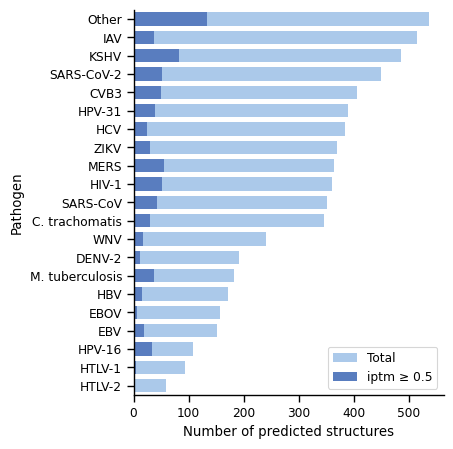

In [18]:
plt.figure(figsize=(4, 5))
sns.set_color_codes("pastel")
sns.barplot(x=both_counts['all_count'], y=both_counts.index,
            label="Total", color="b", gap=0.1)

sns.set_color_codes("muted")
g = sns.barplot(x=both_counts['high_iptm_count'], y=both_counts.index,
            label="iptm ≥ 0.5", color="b", gap=0.1)
#sns.move_legend(g, 'center left', bbox_to_anchor=(1, 0.5))

sns.despine()

plt.ylabel('Pathogen')
plt.xlabel('Number of predicted structures')
#plt.legend(ncol=1, loc="center right", frameon=True)
plt.savefig('../results/plots_apms_hpidb/pathogen_num_structures_krogan_hpidb.svg', bbox_inches='tight')
plt.show()